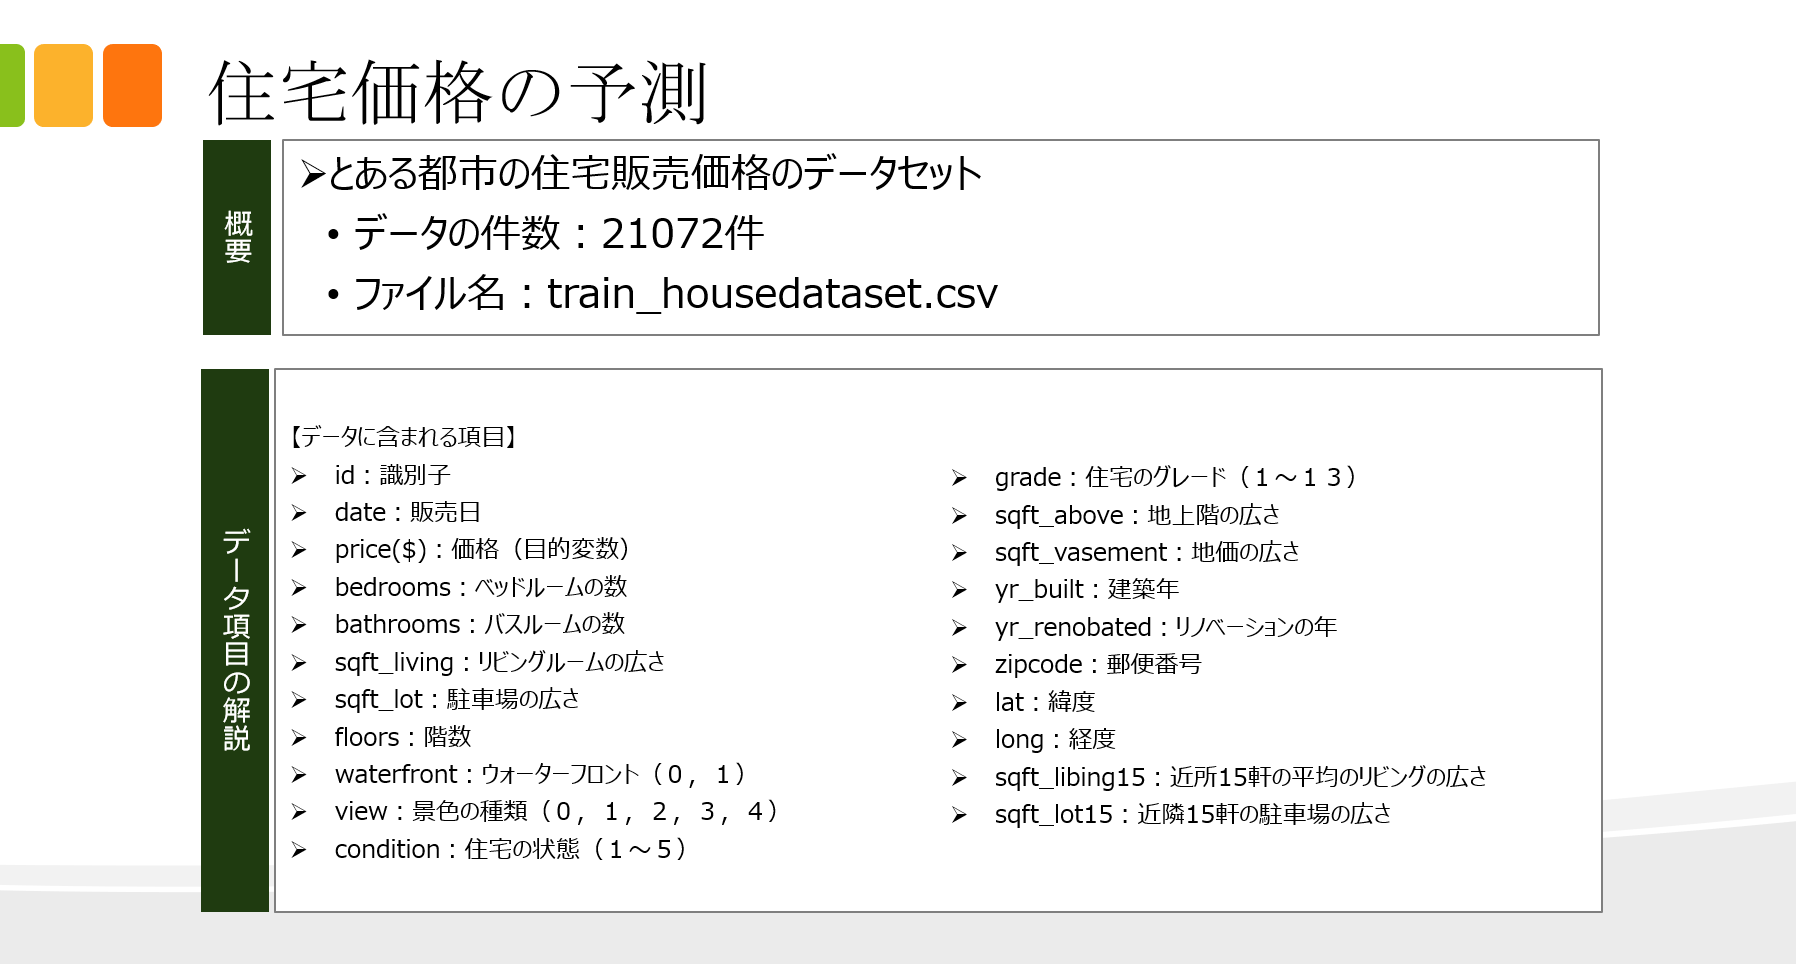

In [ ]:
# ライブラリの読み込み
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.model_selection import KFold

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# データの読み込み
df = pd.read_csv('data/train_housedata.csv')
print(df.shape)
df.head()

In [ ]:
#　ｙ：目的変数　ｘ：説明変数 にデータを分割
y = df['price']
X = df[['bedrooms', 'bathrooms', 'sqft_living','sqft_lot', 'floors',
        'waterfront', 'view', 'condition', 'grade','sqft_above', 
        'sqft_basement', 'yr_built', 'yr_renovated', 
        'sqft_living15', 'sqft_lot15']]

# 型変更
y = y.astype(float)
X = X.astype(float)

# トレインデータとテストデータに分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=1)

print('y_train:',y_train.shape)
print('y_test:',y_test.shape)
print('X_train:',X_train.shape)
print('X_test:',X_test.shape)
y_train.head()
X_train.head()

In [ ]:
def get_model(model_nums):
    models = []
    depth = [3, 4, 5, 6, 7]
    batch_size = [192,256,384]
    for key in model_nums.keys():
        for i in range(model_nums[key]):
            max_depth = depth[i % (len(depth) - 1)]
            num_leaves = 2 ** max_depth
            
            if key == "r":
                models.append(Ridge())
            elif key == "l":
                models.append(Lasso())
            elif key == "en":
                models.append(ElasticNet())
            elif key == "rfc":
                models.append(RandomForestRegressor(n_estimators=200, random_state=i, max_depth=max_depth, max_leaf_nodes=num_leaves))
            elif key == "nn":
                learning_rate = 0.01#(i + 1) * 0.01
                if i % 2 == 0:
                    activation = 'relu'
                else:
                    activation = 'tanh'

                models.append(MLPRegressor(activation=activation, hidden_layer_sizes=(128,64,32,16,), max_iter=300,
                                                  solver='adam', learning_rate_init=learning_rate, learning_rate='adaptive', random_state=i))
            elif key == "gbr":
                models.append(GradientBoostingRegressor(n_estimators=200, random_state=i, max_depth=max_depth, max_leaf_nodes=num_leaves))
            elif key == "ada":
                models.append(AdaBoostRegressor(n_estimators=200, random_state=i))
            elif key == "ext":
                models.append(ExtraTreesRegressor(n_estimators=200, random_state=i, max_depth=max_depth, max_leaf_nodes=num_leaves))
    return models

In [ ]:
def train_stage(models, train_x, train_y, boost=False):
    print("学習開始")
    for i, model in enumerate(models):
        print("モデル" + str(i) + " : " + str(type(model)))

        # ブートストラップ再標本
        if boost:
            #samples_x = train_x.sample(n=int(len(train_x) * 0.9), replace=True, random_state=i)
            #samples_y = train_y.sample(n=int(len(train_y) * 0.9), replace=True, random_state=i)
            samples_x = train_x.sample(n=len(train_x), replace=True, random_state=i)
            samples_y = train_y.sample(n=len(train_y), replace=True, random_state=i)
        else:
            samples_x = train_x
            samples_y = train_y

        model.fit(samples_x, samples_y)

In [ ]:
def predict_stage(models, train_x):
    predicts = {}
    for i, model in enumerate(models):
        predicts[i] = model.predict(train_x)

    predict = pd.DataFrame(predicts)
    
    return predict

In [ ]:
# スタッキングアンサンブル学習
# stage1 モデル
stage1_model_nums = {"r":1,"l":0,"en":0, "rfc":0,"nn":30,"gbr":10,"ada":0,"ext":0}
stage1_models = get_model(stage1_model_nums)

# stage2 モデル
stage2_model_nums = {"r":1,"l":0,"en":0,"rfc":0,"nn":10,"gbr":5,"ada":0,"ext":0}
stage2_models= get_model(stage2_model_nums)

# stage3 モデル
stage3_model_nums = {"r":1,"l":0,"en":0,"rfc":0,"nn":0,"gbr":1,"ada":0,"ext":0}
stage3_models = get_model(stage3_model_nums)

# stage4 モデル
stage4_model_nums = {"r":1,"l":0,"en":0,"rfc":0,"nn":0,"gbr":0,"ada":0,"ext":0}
stage4_models = get_model(stage4_model_nums)

# Finalモデル
final_model_nums = {"r":1,"l":0,"en":0,"rfc":0,"nn":0,"gbr":0,"ada":0,"ext":0}
final_models = get_model(final_model_nums)



print("stage1")
train_stage(stage1_models, X_train, y_train, False)

print("stage2")
pre_1 = predict_stage(stage1_models, X_train)
train_stage(stage2_models, pre_1, y_train, False)

print("stage3")
pre_2 = predict_stage(stage2_models, pre_1)
train_stage(stage3_models, pre_2, y_train, False)

print("stage4")
pre_3 = predict_stage(stage3_models, pre_2)
train_stage(stage4_models, pre_3, y_train, False)

print("final")
pre_4 = predict_stage(stage4_models, pre_3)
train_stage(final_models, pre_4, y_train, False)

In [ ]:
# 予測
# train
pre_1 = predict_stage(stage1_models, X_train)
pre_2 = predict_stage(stage2_models, pre_1)
pre_3 = predict_stage(stage3_models, pre_2)
pre_4 = predict_stage(stage4_models, pre_3)
pred_train = predict_stage(final_models, pre_4)


# test
pre_1 = predict_stage(stage1_models, X_test)
pre_2 = predict_stage(stage2_models, pre_1)
pre_3 = predict_stage(stage3_models, pre_2)
pre_4 = predict_stage(stage4_models, pre_3)
pred_test = predict_stage(final_models, pre_4)



In [ ]:
# 評価RMSE
from sklearn.metrics import mean_squared_error as MSE
print('train:', np.sqrt(MSE(y_train,pred_train)))
print('test:', np.sqrt(MSE(y_test,pred_test)))

# グラフチェック
x = np.linspace(0, y_test.max(), 2)
plt.figure(figsize=(5,5))
plt.scatter(y_test, pred_test)
plt.plot(x, x, color='red')
plt.xlabel('Actual')
plt.ylabel('Predict')
plt.show()

### test_housedata.csvのpriceを予測する

In [ ]:
# テストデータの読み込み (未知のデータ、priceを予測する）
df_test = pd.read_csv('data/test_housedata.csv')
df_test.head()

In [ ]:
# モデルを作った時と同じデータの形にする

pred_X = df_test[['bedrooms', 'bathrooms', 'sqft_living','sqft_lot', 'floors',
        'waterfront', 'view', 'condition', 'grade','sqft_above', 
        'sqft_basement', 'yr_built', 'yr_renovated', 
        'sqft_living15', 'sqft_lot15']]

pred_X = pred_X.astype(float)
print(pred_X.shape)
pred_X.head()

In [ ]:
# 予測
pre_1 = predict_stage(stage1_models, pred_X)
pre_2 = predict_stage(stage2_models, pre_1)
pre_3 = predict_stage(stage3_models, pre_2)
pre_4 = predict_stage(stage4_models, pre_3)
pred = predict_stage(final_models, pre_4)

pred.head()

## 本番検証

In [ ]:
# priceがあるデータを読み込み
answer = pd.read_csv('data/answer_housedata.csv')
price = answer['price']
answer.head()

In [ ]:
# 評価RMSE
print('RMSE:', np.sqrt(MSE(price, pred)))

# グラフチェック
x = np.linspace(0, price.max(), 2)
plt.figure(figsize=(5,5))
plt.scatter(price, pred)
plt.plot(x, x, color='red')
plt.xlabel('Actual')
plt.ylabel('Predict')
plt.show()